In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
%%capture
!pip install segment_anything
!pip install roboflow

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
import glob
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

import json
import toml
import os
import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np

import torchvision.transforms as transforms
from pycocotools.coco import COCO
from segment_anything import sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from torch.utils.data import DataLoader, Dataset
import logging
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.nn as nn
from typing import List, Dict, Any

## Necessary function

In [13]:
def plot_results(losses, ious):
  """
  Plots best losses, best IoUs, losses, and IoUs on separate graphs.

  Args:
    bestlosses: A NumPy array of best losses.
    bestious: A NumPy array of best IoUs.
    losses: A NumPy array of losses.
    ious: A NumPy array of IoUs.
  """

  import matplotlib.pyplot as plt

  fig, ax1 = plt.subplots()

  # Plot losses on primary y-axis
  color1 = 'tab:blue'
  ax1.plot(losses, color=color1, label='Losses')
  ax1.set_ylabel('Loss', color=color1)

  # Plot IoUs on secondary y-axis
  color2 = 'tab:orange'
  ax2 = ax1.twinx()
  ax2.plot(ious, color=color2, label='IoUs')
  ax2.set_ylabel('IoU', color=color2)

  # Set common x-axis label and title
  ax1.set_xlabel('Epoch')
  fig.suptitle('Training Results')

  # Plot best losses and IoUs with dashed lines
  #ax1.plot(bestlosses, '--', color=color1, label='Best Losses')
  #ax2.plot(bestious, '--', color=color2, label='Best IoUs')

  # Add legend and show plot
  plt.legend()
  plt.show()


def display_results(percentile = 82):

    with torch.no_grad():
        for i, (images, path, masks) in enumerate(validloader):
            images = images.to(DEVICE)
            temp = images
            masks = masks[0].to(DEVICE)
            total_mask = get_totalmask(masks)
            total_mask = total_mask.to(DEVICE)
            preds, iou = model(images)
            # untrainedpreds, untrainediou = untrained(images)
            preds = preds.to(DEVICE)
            # untrainedpreds = untrainedpreds.to(DEVICE)
            loss = criterion(preds, total_mask)
            # untrainedloss = criterion(untrainedpreds, total_mask)
            probs = torch.sigmoid(preds.squeeze(1))
            # untrainedprobs = torch.sigmoid(untrainedpreds.squeeze(1))
            # print(preds)
            # print(probs)
            probs = probs.cpu().numpy().squeeze()
            # untrainedprobs = untrainedprobs.cpu().numpy().squeeze()
            threshold = np.percentile(probs, percentile)
            # untrainedthreshold = np.percentile(untrainedprobs, percentile)
            # Set the top 10% elements to 1 and the rest to 0
            probs = (probs >= threshold)
            # untrainedprobs = (untrainedprobs >= untrainedthreshold)
            total_mask = total_mask.cpu()

            masks = mask_generator.generate(images[0].permute(1, 2, 0).cpu().numpy())
            untrainedprobs = build_totalmask(masks)
            # print(masks)-d , 0).cpu().numpy())
            # plt.show()

            # visualize
            fig, axs = plt.subplots(1, 4, figsize=(16, 5))
            axs[0].imshow(images[0].permute(1, 2, 0).cpu().numpy())
            axs[0].set_title('Image')
            axs[1].imshow(probs, cmap='gray')
            axs[1].set_title(f'Mask - Threshold: {percentile}%')
            axs[2].imshow(untrainedprobs, cmap='gray')
            axs[2].set_title('Untrained mask')
            axs[3].imshow(total_mask.numpy(), cmap='gray')
            axs[3].set_title('Target mask')
            plt.show()
            print(f'loss: {loss}')
            print(f'iou: {iou}')
            # print(f'untrained loss: {untrainedloss}')
            # print(f'untrained iou: {untrainediou}')


def build_totalmask(pred: List[Dict[str, Any]]) -> np.ndarray:
    """Builds a total mask from a list of segmentations
    ARGS:
        pred (list): list of dicts with keys 'segmentation' and others
    RETURNS:
        total_mask (np.ndarray): total mask

    """

    total_mask = np.zeros(pred[0]['segmentation'].shape, dtype=np.uint8)
    for seg in pred:
        total_mask += seg['segmentation']
    # use cv2 to make image black and white
    _, total_mask = cv2.threshold(total_mask, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


    return total_mask
def build_totalmask(pred: List[Dict[str, Any]]) -> np.ndarray:
    """Builds a total mask from a list of segmentations
    ARGS:
        pred (list): list of dicts with keys 'segmentation' and others
    RETURNS:
        total_mask (np.ndarray): total mask

    """

    total_mask = np.zeros(pred[0]['segmentation'].shape, dtype=np.uint8)
    for seg in pred:
        total_mask += seg['segmentation']
    # use cv2 to make image black and white
    _, total_mask = cv2.threshold(total_mask, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


    return total_mask


class COCODataset(Dataset):
    """
    A PyTorch Dataset to load data from a json file in COCO format.

    ...
    Attributes
    ----------
    root_dir : str
        the root directory containing the images and annotations
    annotation_file : str
        name of the json file containing the annotations (in root_dir)
    transform : callable
        a function/transform to apply to each image

    Methods
    -------
    __getitem__(idx)
        returns the image, image path, and masks for the given index
    buid_total_mask(masks)
        combines the masks into a single mask
    """


    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())

        # Filter out image_ids without any annotations
        self.image_ids = [image_id for image_id in self.image_ids if len(self.coco.getAnnIds(imgIds=image_id)) > 0]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.root_dir, image_info['file_name'])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)
        bboxes = []
        masks = []

        for ann in anns:
            x, y, w, h = ann['bbox']
            bboxes.append([x, y, x + w, y + h])
            mask = self.coco.annToMask(ann)
            masks.append(mask)

        if self.transform:
            image, masks, bboxes = self.transform(image, masks, np.array(bboxes))

        bboxes = np.stack(bboxes, axis=0)
        masks = np.stack(masks, axis=0)
        return image, image_path, torch.tensor(masks).float()

    def get_totalmask(self, masks):
        """get all masks in to one image
        ARGS:
            masks (List[Tensor]): list of masks
        RETURNS:
            total_gt (Tensor): all masks in one image

        """
        total_gt = torch.zeros_like(masks[0][0,:,:])
        for k in range(len(masks[0])):
            total_gt += masks[0][k,:,:]
        return total_gt



class ResizeAndPad:
    """
    Resize and pad images and masks to a target size.

    ...
    Attributes
    ----------
    target_size : int
        the target size of the image
    transform : ResizeLongestSide
        a transform to resize the image and masks
    """

    def __init__(self, target_size):
        self.target_size = target_size
        self.transform = ResizeLongestSide(target_size)
        self.to_tensor = transforms.ToTensor()

    def __call__(self, image, masks, bboxes):
        # Resize image and masks
        og_h, og_w, _ = image.shape
        image = self.transform.apply_image(image)
        masks = [torch.tensor(self.transform.apply_image(mask)) for mask in masks]
        image = self.to_tensor(image)

        # Pad image and masks to form a square
        _, h, w = image.shape
        max_dim = max(w, h)
        pad_w = (max_dim - w) // 2
        pad_h = (max_dim - h) // 2

        padding = (pad_w, pad_h, max_dim - w - pad_w, max_dim - h - pad_h)
        image = transforms.Pad(padding)(image)
        masks = [transforms.Pad(padding)(mask) for mask in masks]

        # Adjust bounding boxes
        bboxes = self.transform.apply_boxes(bboxes, (og_h, og_w))
        bboxes = [[bbox[0] + pad_w, bbox[1] + pad_h, bbox[2] + pad_w, bbox[3] + pad_h] for bbox in bboxes]

        return image, masks, bboxes


def load_datasets(img_size):
    """ load the training and validation datasets in PyTorch DataLoader objects
    ARGS:
        img_size (Tuple(int, int)): image size
    RETURNS:
        train_dataloader (DataLoader): training dataset
        val_dataloader (DataLoader): validation dataset

    """
    transform = ResizeAndPad(1024)
    traindata = COCODataset(root_dir=train,
                        annotation_file=os.path.join(train, annot),
                        transform=transform)
    valdata = COCODataset(root_dir=valid,
                      annotation_file=os.path.join(valid, annot),
                      transform=transform)
    testdata = COCODataset(root_dir=test,
                      annotation_file=os.path.join(test, annot),
                      transform=transform)
    train_dataloader = DataLoader(traindata,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=1)
    val_dataloader = DataLoader(valdata,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=1)
    test_dataloader = DataLoader(testdata,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=1)

    return train_dataloader, val_dataloader, test_dataloader



class ModelSimple(nn.Module):
    """
    Wrapper for the sam model to to fine-tune the model on a new dataset

    ...
    Attributes:
    -----------
    freeze_encoder (bool): freeze the encoder weights
    freeze_decoder (bool): freeze the decoder weights
    freeze_prompt_encoder (bool): freeze the prompt encoder weights
    transform (ResizeLongestSide): resize the images to the model input size

    Methods:
    --------
    setup(): load the model and freeze the weights
    forward(images, points): forward pass of the model, returns the masks and iou_predictions
    """

    def __init__(self, freeze_encoder=True, freeze_decoder=False, freeze_prompt_encoder=True, freeze_percentage=False, percentage=1):
        super().__init__()
        self.freeze_encoder = freeze_encoder
        self.freeze_decoder = freeze_decoder
        self.freeze_prompt_encoder = freeze_prompt_encoder
        self.freeze_percentage = freeze_percentage
        self.percentage = percentage
        # we need this to make the input image size compatible with the model
        self.transform = ResizeLongestSide(1024) #This is 1024, because sam was trained on 1024x1024 images

    def setup(self):
        self.model = sam_model_registry['vit_h']('/content/drive/MyDrive/Computer Vision Project/finetunesam/sam_vit_h_4b8939.pth')
        # to speed up training time, we normally freeze the encoder and decoder
        if self.freeze_encoder:
            for param in self.model.image_encoder.parameters():
                param.requires_grad = False
        if self.freeze_prompt_encoder:
            for param in self.model.prompt_encoder.parameters():
                param.requires_grad = False
        if self.freeze_decoder:
            for param in self.model.mask_decoder.parameters():
                param.requires_grad = False
        # for name, module in self.model.mask_decoder.named_modules():
        #     for name, module in model.named_modules():
        #         if isinstance(module, nn.Linear):  # Check if the module is a Linear layer
        #             if module.out_features == 32:
        #                 continue  # Do not freeze this layer
        #         # Freeze parameters in this module
        #         for param in module.parameters():
        #             param.requires_grad = False
        if self.freeze_percentage:
        # Step 1: Collect all modules
            all_modules = list(self.model.mask_decoder.modules())
            num_modules_unfreeze = int(len(all_modules) * self.percentage)
            for module in all_modules:
                for param in module.parameters():
                    param.requires_grad = False
            for module in all_modules[-num_modules_unfreeze:]:
                for param in module.parameters():
                    param.requires_grad = True

        self.transfrom = ResizeLongestSide(self.model.image_encoder.img_size)
    def forward(self, images):
        _, _, H, W = images.shape # batch, channel, height, width
        image_embeddings = self.model.image_encoder(images) # shape: (1, 256, 64, 64)
        # get prompt embeddings without acutally any prompts (uninformative)
        sparse_embeddings, dense_embeddings = self.model.prompt_encoder(
            points=None,
            boxes=None,
            masks=None,
        )

        # print(f"image_embeddings shape: {image_embeddings.shape}")
        # temp = image_embeddings[0].cpu().numpy()
        # # fig, axes = plt.subplots(2, 4, figsize=(12, 6))
        # # for i, ax in enumerate(axes.flat):
        # #     ax.imshow(temp[i, :, :], cmap='gray')
        # #     ax.set_title(f"Filter {i+1}")
        # #     ax.axis('off')
        # superimposed_image = np.mean(temp[:, :, :], axis=0)
        # # Display the superimposed image
        # plt.figure(figsize=(6, 6))
        # plt.imshow(superimposed_image, cmap='gray')
        # plt.title("Superimposed Filters")
        # plt.axis('off')
        # plt.show()
        # plt.tight_layout()
        # plt.show()
        # get low resolution masks and iou predictions
        # mulitmask_output=False means that we only get one mask per image,
        # otherwise we would get three masks per image
        low_res_masks, iou_predictions = self.model.mask_decoder(
            image_embeddings=image_embeddings,
            image_pe=self.model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings, # sparse_embeddings shape: (1, 0, 256)
            dense_prompt_embeddings=dense_embeddings, # dense_embeddings shape: (1, 256, 256)
            multimask_output=False,
        )
        # postprocess the masks to get the final masks and resize them to the original image size
        masks = F.interpolate(
            low_res_masks, # shape: (1, 1, 256, 256)
            (H, W),
            mode="bilinear",
            align_corners=False,
        )
        # shape masks after interpolate: torch.Size([1, 1, 1024, 1024])
        return masks, iou_predictions

import torch.nn as nn
import torch.nn.functional as F
import torch

def get_totalmask(masks):
    """get all masks in to one image
    ARGS:
        masks (torch.Tensor): shape: (N, H, W) where N is the number of masks
                              masks H,W is usually 1024,1024
    RETURNS:
        total_gt (torch.Tensor): all masks in one image

    """
    total_gt = torch.zeros_like(masks[0,:,:])
    for k in range(len(masks)):
        total_gt += masks[k,:,:]
    return total_gt



class FocalLoss(nn.Module):
    """ Computes the Focal loss. """

    def __init__(self):
        super().__init__()

    def forward(self, inputs, targets):

        inputs = inputs.flatten(0,2)
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1 - BCE_EXP)**gamma * BCE

        return focal_loss


class DiceLoss(nn.Module):
    """ Computes the Dice loss. """

    def __init__(self):
        super().__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = F.sigmoid(inputs)
        inputs = inputs.flatten(0,2)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / \
            (inputs.sum() + targets.sum() + smooth)
        return 1 - dice



def criterion(x, y):
    """ Combined dice and focal loss.
    ARGS:
        x: (torch.Tensor) the model output
        y: (torch.Tensor) the target
    RETURNS:
        (torch.Tensor) the combined loss

    """
    focal, dice = FocalLoss(), DiceLoss()
    y = y.to(DEVICE)
    x = x.to(DEVICE)
    return 20 * focal(x, y) + dice(x, y)


def train_one_epoch(model, trainloader, optimizer, epoch_idx): # , tb_writer for tensroboard
    """ Runs forward and backward pass for one epoch and returns the average
    batch loss for the epoch.
    ARGS:
        model: (nn.Module) the model to train
        trainloader: (torch.utils.data.DataLoader) the dataloader for training
        optimizer: (torch.optim.Optimizer) the optimizer to use for training
        epoch_idx: (int) the index of the current epoch
        tb_writer: (torch.utils.tensorboard.writer.SummaryWriter) the tensorboard writer
    RETURNS:
        last_loss: (float) the average batch loss for the epoch

    """
    running_loss = 0.
    for i, (image, path, masks) in enumerate(trainloader):
        image = image.to(DEVICE)
        optimizer.zero_grad()
        pred, _ = model(image)
        # print(f'pred shape: {pred.shape}')
        masks = masks[0].to(DEVICE)
        total_mask = get_totalmask(masks)
        pred = pred.to(DEVICE)
        loss = criterion(pred, total_mask)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    i = len(trainloader)
    last_loss = running_loss / i
    # print(f'batch_loss for batch {i}: {last_loss}')
    # tb_x = epoch_idx * len(trainloader) + i + 1
    # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
    running_loss = 0.
    return last_loss



def save_checkpoint(state, filename="checkpoint.pth.tar"):
    """Saves the model and training parameters at the specified path. Useful for resuming training."""
    torch.save(state, filename)

def training(epochs=5, learning_rate = 0.001, dir_checkpoint = "/content/drive/MyDrive/Computer Vision Project/finetunesam_apr24"):
    """Trains the model for the given number of epochs."""
    model = ModelSimple()
    model.setup()
    model.to(DEVICE)
    img_size = model.model.image_encoder.img_size
    trainloader, validloader, _ = load_datasets(img_size=img_size)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=0.0001)  # Example lr and weight_decay
    best_valid_loss = float('inf')
    best_iou_loss = float('-inf')
    losses = []
    ious = []
    bestlosses = []
    bestious = []
    print(f'training for {epochs} epochs')
    for epch in range(epochs):
        running_vloss = 0.
        iou_loss = 0.
        model.train(True)
        avg_batchloss = train_one_epoch(model, trainloader, optimizer, epch)
        # if eval is a keyword you're using, it should be defined elsewhere; otherwise, it might be a typo.
        model.eval()
        with torch.no_grad():
            for i, (images, path, masks) in enumerate(validloader):
                images = images.to(DEVICE)
                masks = masks[0].to(DEVICE)
                total_mask = get_totalmask(masks)
                total_mask = total_mask.to(DEVICE)
                preds, iou = model(images)
                preds = preds.to(DEVICE)
                vloss = criterion(preds, total_mask)
                running_vloss += vloss.item()
                iou_loss += iou.item()
        avg_vloss = running_vloss / len(validloader)
        avg_iou = iou_loss / len(validloader)
        losses.append(avg_vloss)
        ious.append(avg_iou)
        bestlosses.append(best_valid_loss)
        bestious.append(best_iou_loss)
        print(f'Epoch {epch}: Valid Loss {avg_vloss}, IOU {avg_iou}')
        if avg_vloss < best_valid_loss:
            best_valid_loss = avg_vloss
            save_checkpoint({
                'epoch': epch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'loss': best_valid_loss,
                'iou': avg_iou,
            }, filename=f"{dir_checkpoint}/best_model_vloss_{epch}.pth.tar")
        if avg_iou > best_iou_loss:
            best_iou_loss = avg_iou
            save_checkpoint({
                'epoch': epch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'loss': avg_vloss,
                'iou': best_iou_loss,
            }, filename=f"{dir_checkpoint}/best_model_iou_{epch}.pth.tar")
    return model, bestlosses, bestious, losses, ious


"""

# next add train function for prompting model with points (ModelAll)
# next unrelated find out how to get tensor output of masks form SamAutomaticMaskGenerator
"""




'\n\n# next add train function for prompting model with points (ModelAll)\n# next unrelated find out how to get tensor output of masks form SamAutomaticMaskGenerator\n'

## Changes that have been so far



*   added epochs
*   ability load from the best model in training checkpoints
*   ability to set learning rate
*   Loop over threshold when making prediction on validation



# Path to roboflow folder

In [12]:
folder = '/content/drive/MyDrive/Computer Vision Project/datasets/MultiTag/highway'

# Params and functions

In [14]:
from torch.types import Device
#data
global train
global test
global annot

# TODO: Put your path here !!!!

train = f"{folder}/train"
valid = f"{folder}/valid"
test = f"{folder}/test"
annot = "_annotations.coco.json"
# train = "/content/drive/MyDrive/finetunesam/train"
# test = "/content/drive/MyDrive/finetunesam/test"
# annot = "annotations.json"
#model
global batch_size
global epochs
global lr
global weight_decay
global DEVICE

# TODOD adjust, if needed!!!!
batch_size = 1
epochs = 1
lr = 0.001
weight_decay = 0.0005
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# loss
global alpha
global gamma
alpha = 0.8
gamma = 2




cuda


## load the initial model

In [15]:
model = sam_model_registry['vit_h']('/content/drive/MyDrive/Computer Vision Project/finetunesam/sam_vit_h_4b8939.pth')

In [16]:
#from roboflow import Roboflow
#rf = Roboflow(api_key="ZgskaiCzxYnJx1kwRctg")
#project = rf.workspace("datasethouseyolo").project("example-building-detection")
#version = project.version(1)
#dataset = version.download("coco")

## 01 Segment image with SAM test on an image
Now we'll quickly use the wrapper classes from SAM, to segment our images, and we'll see why we need to fine-tune the model directly later. If you have not done so, you need to download the sam model see [here](https://github.com/facebookresearch/segment-anything/tree/main#model-checkpoints).

Segment anything provides a class "SamAutomaticMaskGenerator". This class generates all masks for the whole image. However, it returns each mask separately, that's why we need a helper function to combine all masks in one image.

In [17]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

mask_generator = SamAutomaticMaskGenerator(model)

In [18]:
model.to(DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

<class 'list'>
130
<class 'dict'>
keys of dict: dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
Shape of masks: (1024, 1024)
Value counts in segmentation of first mask:
(array([False,  True]), array([961373,  87203]))


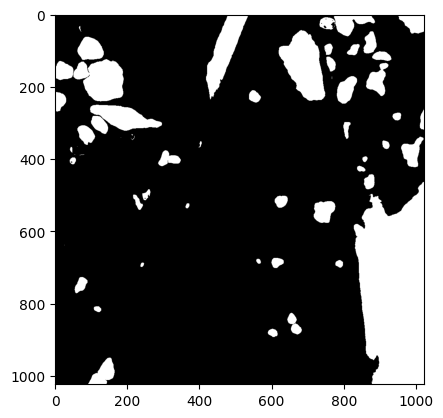

In [19]:
# # generate masks and investigate object
# # hint: run this with GPU support
img = plt.imread("/content/drive/MyDrive/Computer Vision Project/datasets/MultiTag/highway/test/Highway_Brazil_-_eBee_X_-_S-O-D-A-3-_png.rf.7fdfe599e18a81983d27b14d27974016.jpg")
masks = mask_generator.generate(img)
print(type(masks))
print(len(masks))
print(type(masks[0]))
print(f'keys of dict: {masks[0].keys()}')
print(f"Shape of masks: {masks[0]['segmentation'].shape}")
print('Value counts in segmentation of first mask:')
print(np.unique(masks[0]['segmentation'], return_counts=True))
total_mask = build_totalmask(masks)
plt.imshow(total_mask, cmap='gray')

----

In [20]:
trainloader, validloader, testloader = load_datasets(1024)
# print(len(validloader))
sample_img = trainloader.dataset[1][0]
# print(sample_img)
sample_mask = trainloader.dataset[1][2]

loading annotations into memory...
Done (t=1.46s)
creating index...
index created!
loading annotations into memory...
Done (t=1.50s)
creating index...
index created!
loading annotations into memory...
Done (t=0.71s)
creating index...
index created!


In [21]:
trainloader.dataset[1][2].shape

torch.Size([17, 1024, 1024])

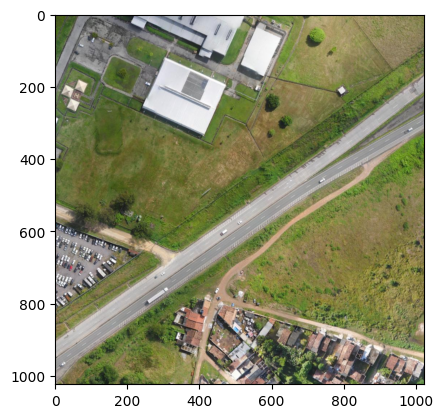

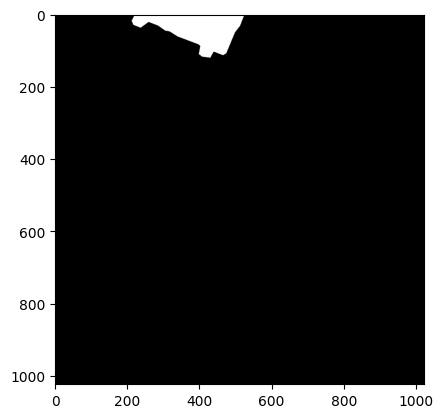

In [22]:
plt.imshow(sample_img.permute(1, 2, 0).numpy())
plt.show()
plt.imshow(sample_mask[3].numpy(), cmap='gray')
plt.show()

In [23]:
# from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

# sam = sam_model_registry["vit_h"](checkpoint="/content/drive/MyDrive/finetunesam/sam_vit_h_4b8939.pth") #TODO your path here
# sam.to(DEVICE)
# mask_generator = SamAutomaticMaskGenerator(sam)
# masks = mask_generator.generate(img)
# total_mask = build_totalmask(masks)

In [24]:
# # # generate masks and investigate object
# # # hint: run this with GPU support
# imgpath = "/content/drive/MyDrive/desert/train/Cyark_-_Shirk_Ranch_-_eBee_X-1-_png.rf.9f6d682676b72c0141d6b4af20c9a014.jpg"
# annpath = "/content/drive/MyDrive/desert/train/_annotations.coco.json"
# img = plt.imread(imgpath)
# masks = mask_generator.generate(img)
# print(type(masks))
# print(len(masks))
# print(type(masks[0]))
# print(f'keys of dict: {masks[0].keys()}')
# print(f"Shape of masks: {masks[0]['segmentation'].shape}")
# print('Value counts in segmentation of first mask:')
# print(np.unique(masks[0]['segmentation'], return_counts=True))
# total_mask = build_totalmask(masks)
# plt.imshow(img)
# plt.show()
# plt.imshow(total_mask, cmap='gray')
# plt.show()



---



# Training - Fine tunning SAM

### Simple test

In [ ]:
model = ModelSimple()
model.setup()
model.train()
img_size = model.model.image_encoder.img_size
print(img_size)

1024


## Real Fine tunning

In [26]:

# for percentile from 5 to 95 with 5 step
for epc in [10, 15]:
    for lr in [0.001, 0.01, 0.1]:

        # MODEL BASED - NOT FINED TUNED
        model = sam_model_registry['vit_h']('/content/drive/MyDrive/Computer Vision Project/finetunesam/sam_vit_h_4b8939.pth')

        dir_name = f"{epc}_{lr}".replace(".", "_")
        print(f"------------------------------------------------ \n Training for {dir_name}")

        # create a folder with the name of epc and lr
        if not os.path.exists(f"/content/drive/MyDrive/Computer Vision Project/finetunesam_apr24/{dir_name}"):
            os.makedirs(f"/content/drive/MyDrive/Computer Vision Project/finetunesam_apr24/{dir_name}")

        model, bestlosses, bestious, losses, ious = training(epochs=epc, learning_rate = lr, dir_checkpoint = f"/content/drive/MyDrive/Computer Vision Project/finetunesam_apr24/{dir_name}")



        best_epoch = np.argmax(ious)

        # Load the checkpoint
        checkpoint = torch.load(f"/content/drive/MyDrive/Computer Vision Project/finetunesam_apr24/{dir_name}/best_model_iou_{best_epoch}.pth.tar")

        # Remove 'model.' prefix from state_dict keys
        state_dict = {key.replace("model.", ""): value for key, value in checkpoint['state_dict'].items()}

        # Initialize the SAM model
        sam = sam_model_registry["vit_h"]()

        # Load the adjusted state dictionary into the SAM model
        sam.load_state_dict(state_dict)
        sam.to(DEVICE)

        display_results(percentile=50)

        plot_results(losses, ious)


------------------------------------------------ 
 Training for 10_0_001
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
training for 10 epochs


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 189.06 MiB is free. Process 70896 has 14.56 GiB memory in use. Of the allocated memory 13.37 GiB is allocated by PyTorch, and 1.04 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)



---


## Load the the best fined tunned model from the epochs

In [ ]:
ious

NameError: name 'ious' is not defined

In [ ]:
best_epoch = 3
# Load the checkpoint
checkpoint = torch.load(f"/content/drive/MyDrive/Computer Vision Project/finetunesam_apr24/best_model_iou_{best_epoch}.pth.tar")

# Remove 'model.' prefix from state_dict keys
state_dict = {key.replace("model.", ""): value for key, value in checkpoint['state_dict'].items()}

# Initialize the SAM model
sam = sam_model_registry["vit_h"]()

# Load the adjusted state dictionary into the SAM model
sam.load_state_dict(state_dict)
sam.to(DEVICE)


NameError: name 'torch' is not defined

In [ ]:
#import matplotlib.pyplot as plt
#model.to(DEVICE)
#model.eval()
#sam = sam_model_registry["vit_h"](checkpoint="/content/drive/MyDrive/Computer Vision Project/finetunesam/sam_vit_h_4b8939.pth") #TODO your path here
#sam.to(DEVICE)
#mask_generator = SamAutomaticMaskGenerator(sam)
# masks = mask_generator.generate(img)
# total_mask = build_totalmask(masks)
# mask_generator = SamAutomaticMaskGenerator(model.model)
#temp = None

# untrained = ModelSimple()
# untrained.setup()
# untrained.to(DEVICE)
# untrained.eval()
#pass

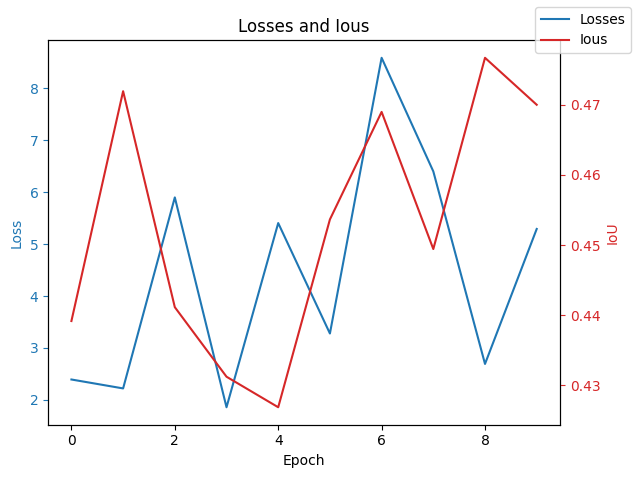

In [ ]:
# prompt: code to plot bestlosses, bestious one one graph and losses, ious on another graphs

# bestlosses = np.array(bestlosses)
# bestious = np.array([x for x in bestious])
# losses = np.array(losses)
# ious = np.array([x for x in ious])

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

# Plot losses on primary y-axis
color1 = 'tab:blue'
ax1.plot(losses, label="Losses", color=color1)
ax1.set_ylabel("Loss", color=color1)

# Create a secondary y-axis for ious
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.plot(ious, label="Ious", color=color2)
ax2.set_ylabel("IoU", color=color2)

# Position the y-axis on separate sides
ax1.yaxis.label.set_color(color1)
ax2.yaxis.label.set_color(color2)
ax1.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

# Common x-axis label
ax1.set_xlabel("Epoch")
plt.title("Losses and Ious")

# Legend for both plots
fig.tight_layout()
fig.legend()

# Show the plot
plt.show()

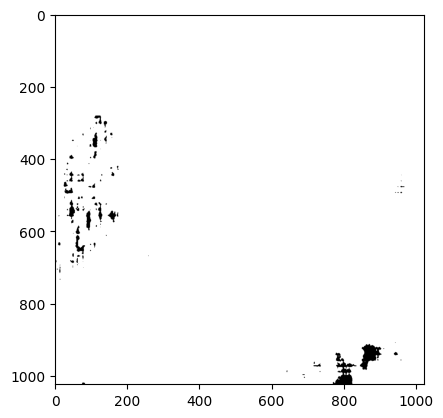

In [ ]:
# prompt: write code that applies the model to the image and then plots the model's masks after thresholding like I did before
img = plt.imread("/content/example-building-detection-1/train/house-dataset-10_jpg.rf.d36104aa02b6543084f82777a518d9ce.jpg").astype(np.float32)
img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)
img = img.to(DEVICE)
resize_transform = transforms.Resize((1024, 1024))
img = resize_transform(img)
preds, iou = model(img)
preds = preds.to(DEVICE)
probs = torch.sigmoid(preds.squeeze(1))
probs = probs.detach().cpu().numpy().squeeze()
threshold = np.percentile(probs, 0.95)
probs = (probs >= threshold)

# visualize
plt.imshow(probs, cmap='gray')
plt.show()

In [ ]:
# Freeze percentage - 100% 50% 10% 1%
# Change loss weightage - 40:1 20:1 10:1 5:1
# change epochs - 20 10 5 1